In [31]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.svm import SVR

from catboost import CatBoostRegressor


import xgboost as xgb
print("xgboost", xgb.__version__)

xgboost 1.3.3


In [2]:
df = pd.read_csv("data/avocado.csv")

In [3]:
data = df.copy()

In [4]:
data = data.drop(['Unnamed: 0'],axis = 1)

In [5]:
data.Date

0        2015-12-27
1        2015-12-20
2        2015-12-13
3        2015-12-06
4        2015-11-29
            ...    
18244    2018-02-04
18245    2018-01-28
18246    2018-01-21
18247    2018-01-14
18248    2018-01-07
Name: Date, Length: 18249, dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [7]:
data.describe(include = 'all')

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
count,18249,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249,18249.000000,18249
unique,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,54
top,2015-12-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conventional,NaN,West
freq,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9126,NaN,338
mean,NaN,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,NaN,2016.147899,NaN
std,NaN,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,NaN,0.939938,NaN
min,NaN,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,2015.000000,NaN
25%,NaN,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,NaN,2015.000000,NaN
50%,NaN,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,NaN,2016.000000,NaN
75%,NaN,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,NaN,2017.000000,NaN


In [8]:
data["Date"] = pd.to_datetime(data["Date"])
data["month"] = data["Date"].dt.month
data["day"] = data["Date"].dt.day


In [9]:


scatter = go.Scatter(x = data.groupby('Date').mean().index, y = data.groupby('Date').mean().AveragePrice , name = 'avg price')

layout = go.Layout(title = 'Time series plot for mean daily prices for all regions', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter], layout = layout)
iplot(figure)

In [10]:
#renaming columns

rename_columns = list(data.columns)
rename_columns = [x.lower() for x in rename_columns]
data.columns = rename_columns
data = data.rename(columns = lambda x: x.replace(' ','_'))

In [11]:
data

,date,averageprice,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,month,day
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,27
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,20
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,13
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,6
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico,2,4
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico,1,28
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico,1,21
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico,1,14


In [12]:
#Transforming categorical values 

def label_enconcode_pre(df):
    if df.dtype == 'object':
        df = LabelEncoder().fit_transform(df)
    return df

data = data.apply(lambda x: label_enconcode_pre(x))

In [13]:
data = pd.get_dummies(data, columns=['year','type','region'], drop_first= True)

In [14]:
data = data.set_index('date')

In [15]:
split_date = '2017-07-30'
data_train = data.loc[data.index <= split_date]
data_test = data.loc[data.index > split_date]

scatter = go.Scatter(x = data_train.groupby('date').mean().index, y = data_train.groupby('date').mean().averageprice , name = 'train')
scatter2 = go.Scatter(x = data_test.groupby('date').mean().index, y = data_test.groupby('date').mean().averageprice, name = 'test')

layout = go.Layout(title = 'Time series plot for mean daily prices for all regions', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter, scatter2], layout = layout)
iplot(figure)

In [16]:
# Train / Test split

X_train = data_train.drop(['averageprice'], axis = 1)
y_train = data_train['averageprice']

X_test = data_test.drop(['averageprice'], axis = 1)
y_test = data_test['averageprice']

### test

In [17]:
standard_scaler_pre = []
for i in data.columns:
    if data[i].dtype == 'int32' or data[i].dtype == 'int64':
        standard_scaler_pre += [i]
ss = StandardScaler()
X_train[standard_scaler_pre] = ss.fit_transform(X_train[standard_scaler_pre])
X_test[standard_scaler_pre] = ss.transform(X_test[standard_scaler_pre])

In [18]:
regressors = [['ElasticNet', ElasticNetCV()],
             ['SVR', SVR()],
             ['XGB', xgb.XGBRegressor()]
             ]

print('Mean absolute error results:')
result_regressors = dict()
for name, regressor in regressors:
    reg = regressor
    reg.fit(X_train, y_train)
    mae = cross_val_score(reg, X_test, y_test, cv = 10, n_jobs =-1, scoring = 'neg_mean_absolute_error')
    print(name, -np.mean(mae))
    result_regressors[name] = -np.mean(mae)

Mean absolute error results:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4456410139412128, tolerance: 0.1927316279411765

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7916992223515535, tolerance: 0.1927316279411765

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.0857851864077475, tolerance: 0.1927316279411765

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.40128109057332, t

ElasticNet 0.31295217668797176
SVR 0.2649883696286316
XGB 0.15115756088429583


### SVR

In [19]:
svr = SVR()
svr.fit(X_train,y_train)
data_test["averageprice_prediction"] = svr.predict(X_test)
data_all = pd.concat([data_test, data_train], sort = False)
data_all[['averageprice', 'averageprice_prediction']].sort_values('date')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,averageprice,averageprice_prediction
date,,
2015-01-04,1.75,NaN
2015-01-04,1.83,NaN
2015-01-04,1.22,NaN
2015-01-04,1.64,NaN
2015-01-04,0.89,NaN
...,...,...
2018-03-25,1.21,1.237355
2018-03-25,1.37,0.812065
2018-03-25,1.45,1.394819


In [20]:
scatter = go.Scatter(x = data.groupby('date').mean().index, y = data.groupby('date').mean().averageprice , name = 'actual')
scatter2 = go.Scatter(x = data_all.groupby('date').mean().index, y = data_all.groupby('date').mean().averageprice_prediction, name = 'forecast')

layout = go.Layout(title = 'SVR time series forecast', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter, scatter2], layout = layout)
iplot(figure)

mse = mean_squared_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])
mae = mean_absolute_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])

print("MAE:", mae, "MSE:",mse)

MAE: 0.2792041663195355 MSE: 0.14151658503385564


In [32]:
cbr = CatBoostRegressor(verbose = False)
cbr.fit(X_train,y_train)
data_test["averageprice_prediction"] = cbr.predict(X_test)
data_all = pd.concat([data_test, data_train], sort = False)
print(data_all[['averageprice', 'averageprice_prediction']].sort_values('date'))
scatter = go.Scatter(x = data.groupby('date').mean().index, y = data.groupby('date').mean().averageprice , name = 'actual')
scatter2 = go.Scatter(x = data_all.groupby('date').mean().index, y = data_all.groupby('date').mean().averageprice_prediction, name = 'forecast')

layout = go.Layout(title = 'CatBoost time series forecast', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter, scatter2], layout = layout)
iplot(figure)

mse = mean_squared_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])
mae = mean_absolute_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])

print("MAE:", mae, "MSE:",mse)

Learning rate set to 0.062883
0:	learn: 0.3856492	total: 235ms	remaining: 3m 54s
1:	learn: 0.3733210	total: 248ms	remaining: 2m 3s
2:	learn: 0.3620584	total: 256ms	remaining: 1m 25s
3:	learn: 0.3521725	total: 265ms	remaining: 1m 6s
4:	learn: 0.3425470	total: 273ms	remaining: 54.4s
5:	learn: 0.3336329	total: 282ms	remaining: 46.7s
6:	learn: 0.3249313	total: 290ms	remaining: 41.1s
7:	learn: 0.3176052	total: 298ms	remaining: 37s
8:	learn: 0.3104641	total: 307ms	remaining: 33.8s
9:	learn: 0.3042209	total: 315ms	remaining: 31.2s
10:	learn: 0.2986341	total: 323ms	remaining: 29.1s
11:	learn: 0.2930792	total: 332ms	remaining: 27.3s
12:	learn: 0.2881302	total: 341ms	remaining: 25.9s
13:	learn: 0.2835566	total: 349ms	remaining: 24.6s
14:	learn: 0.2793118	total: 357ms	remaining: 23.4s
15:	learn: 0.2752128	total: 365ms	remaining: 22.4s
16:	learn: 0.2712729	total: 373ms	remaining: 21.6s
17:	learn: 0.2676408	total: 381ms	remaining: 20.8s
18:	learn: 0.2643061	total: 389ms	remaining: 20.1s
19:	learn: 

181:	learn: 0.1576257	total: 1.64s	remaining: 7.39s
182:	learn: 0.1572189	total: 1.65s	remaining: 7.38s
183:	learn: 0.1569307	total: 1.66s	remaining: 7.35s
184:	learn: 0.1566482	total: 1.67s	remaining: 7.34s
185:	learn: 0.1563689	total: 1.67s	remaining: 7.32s
186:	learn: 0.1560881	total: 1.68s	remaining: 7.31s
187:	learn: 0.1557284	total: 1.69s	remaining: 7.29s
188:	learn: 0.1554897	total: 1.7s	remaining: 7.28s
189:	learn: 0.1551708	total: 1.7s	remaining: 7.27s
190:	learn: 0.1549282	total: 1.71s	remaining: 7.25s
191:	learn: 0.1546616	total: 1.72s	remaining: 7.24s
192:	learn: 0.1543759	total: 1.73s	remaining: 7.23s
193:	learn: 0.1541308	total: 1.74s	remaining: 7.21s
194:	learn: 0.1538981	total: 1.74s	remaining: 7.2s
195:	learn: 0.1535885	total: 1.75s	remaining: 7.19s
196:	learn: 0.1533894	total: 1.76s	remaining: 7.18s
197:	learn: 0.1530574	total: 1.77s	remaining: 7.16s
198:	learn: 0.1528454	total: 1.78s	remaining: 7.15s
199:	learn: 0.1525530	total: 1.78s	remaining: 7.14s
200:	learn: 0.1

343:	learn: 0.1273620	total: 2.88s	remaining: 5.49s
344:	learn: 0.1272915	total: 2.89s	remaining: 5.48s
345:	learn: 0.1271625	total: 2.89s	remaining: 5.47s
346:	learn: 0.1270484	total: 2.9s	remaining: 5.46s
347:	learn: 0.1269650	total: 2.9s	remaining: 5.44s
348:	learn: 0.1268123	total: 2.91s	remaining: 5.43s
349:	learn: 0.1265961	total: 2.92s	remaining: 5.43s
350:	learn: 0.1264887	total: 2.93s	remaining: 5.42s
351:	learn: 0.1264049	total: 2.94s	remaining: 5.41s
352:	learn: 0.1262895	total: 2.95s	remaining: 5.4s
353:	learn: 0.1261519	total: 2.95s	remaining: 5.39s
354:	learn: 0.1260716	total: 2.96s	remaining: 5.38s
355:	learn: 0.1259331	total: 2.97s	remaining: 5.37s
356:	learn: 0.1258202	total: 2.98s	remaining: 5.36s
357:	learn: 0.1256551	total: 2.99s	remaining: 5.36s
358:	learn: 0.1255332	total: 2.99s	remaining: 5.35s
359:	learn: 0.1254048	total: 3s	remaining: 5.34s
360:	learn: 0.1252538	total: 3.01s	remaining: 5.33s
361:	learn: 0.1251348	total: 3.02s	remaining: 5.32s
362:	learn: 0.1250

507:	learn: 0.1115366	total: 4.11s	remaining: 3.98s
508:	learn: 0.1114913	total: 4.11s	remaining: 3.97s
509:	learn: 0.1114140	total: 4.12s	remaining: 3.96s
510:	learn: 0.1113116	total: 4.12s	remaining: 3.95s
511:	learn: 0.1112235	total: 4.13s	remaining: 3.94s
512:	learn: 0.1111272	total: 4.14s	remaining: 3.93s
513:	learn: 0.1110698	total: 4.14s	remaining: 3.92s
514:	learn: 0.1110130	total: 4.15s	remaining: 3.91s
515:	learn: 0.1109104	total: 4.16s	remaining: 3.9s
516:	learn: 0.1108425	total: 4.16s	remaining: 3.89s
517:	learn: 0.1107782	total: 4.17s	remaining: 3.88s
518:	learn: 0.1107193	total: 4.18s	remaining: 3.87s
519:	learn: 0.1106668	total: 4.19s	remaining: 3.86s
520:	learn: 0.1105923	total: 4.19s	remaining: 3.86s
521:	learn: 0.1105111	total: 4.2s	remaining: 3.85s
522:	learn: 0.1104504	total: 4.21s	remaining: 3.84s
523:	learn: 0.1103998	total: 4.22s	remaining: 3.83s
524:	learn: 0.1103424	total: 4.22s	remaining: 3.82s
525:	learn: 0.1102203	total: 4.23s	remaining: 3.81s
526:	learn: 0.

671:	learn: 0.1015102	total: 5.32s	remaining: 2.6s
672:	learn: 0.1014479	total: 5.33s	remaining: 2.59s
673:	learn: 0.1013888	total: 5.33s	remaining: 2.58s
674:	learn: 0.1013175	total: 5.34s	remaining: 2.57s
675:	learn: 0.1012401	total: 5.35s	remaining: 2.56s
676:	learn: 0.1011920	total: 5.36s	remaining: 2.56s
677:	learn: 0.1011559	total: 5.36s	remaining: 2.55s
678:	learn: 0.1011227	total: 5.37s	remaining: 2.54s
679:	learn: 0.1010496	total: 5.38s	remaining: 2.53s
680:	learn: 0.1009922	total: 5.39s	remaining: 2.52s
681:	learn: 0.1009173	total: 5.39s	remaining: 2.52s
682:	learn: 0.1008313	total: 5.4s	remaining: 2.51s
683:	learn: 0.1007637	total: 5.41s	remaining: 2.5s
684:	learn: 0.1007313	total: 5.42s	remaining: 2.49s
685:	learn: 0.1006807	total: 5.42s	remaining: 2.48s
686:	learn: 0.1006313	total: 5.43s	remaining: 2.48s
687:	learn: 0.1005905	total: 5.44s	remaining: 2.47s
688:	learn: 0.1005250	total: 5.45s	remaining: 2.46s
689:	learn: 0.1004834	total: 5.46s	remaining: 2.45s
690:	learn: 0.1

851:	learn: 0.0933972	total: 6.73s	remaining: 1.17s
852:	learn: 0.0933585	total: 6.73s	remaining: 1.16s
853:	learn: 0.0933314	total: 6.74s	remaining: 1.15s
854:	learn: 0.0932904	total: 6.75s	remaining: 1.14s
855:	learn: 0.0932474	total: 6.75s	remaining: 1.14s
856:	learn: 0.0932098	total: 6.76s	remaining: 1.13s
857:	learn: 0.0931692	total: 6.77s	remaining: 1.12s
858:	learn: 0.0931268	total: 6.78s	remaining: 1.11s
859:	learn: 0.0930965	total: 6.78s	remaining: 1.1s
860:	learn: 0.0930653	total: 6.79s	remaining: 1.1s
861:	learn: 0.0929980	total: 6.8s	remaining: 1.09s
862:	learn: 0.0929601	total: 6.81s	remaining: 1.08s
863:	learn: 0.0929370	total: 6.82s	remaining: 1.07s
864:	learn: 0.0928984	total: 6.82s	remaining: 1.06s
865:	learn: 0.0928565	total: 6.83s	remaining: 1.06s
866:	learn: 0.0928247	total: 6.84s	remaining: 1.05s
867:	learn: 0.0927827	total: 6.85s	remaining: 1.04s
868:	learn: 0.0927204	total: 6.86s	remaining: 1.03s
869:	learn: 0.0926730	total: 6.86s	remaining: 1.02s
870:	learn: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            averageprice  averageprice_prediction
date                                             
2015-01-04          1.75                      NaN
2015-01-04          1.83                      NaN
2015-01-04          1.22                      NaN
2015-01-04          1.64                      NaN
2015-01-04          0.89                      NaN
...                  ...                      ...
2018-03-25          1.21                 1.172067
2018-03-25          1.37                 0.999269
2018-03-25          1.45                 1.429032
2018-03-25          1.42                 1.048567
2018-03-25          1.28                 1.037415

[18249 rows x 2 columns]


MAE: 0.20701117766366908 MSE: 0.0763640963760952


### XGBoost model 

In [21]:


reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False, ) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

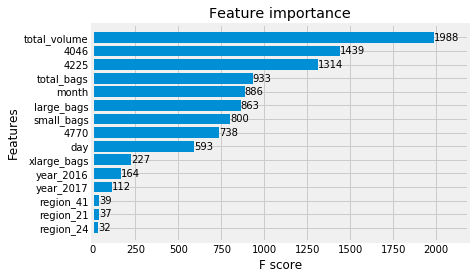

In [22]:
from xgboost import plot_importance, plot_tree
plot_importance(reg, height=0.8, max_num_features=15)

In [23]:
data_test["averageprice_prediction"] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort = False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
data_all[['averageprice', 'averageprice_prediction']].sort_values('date')

,averageprice,averageprice_prediction
date,,
2015-01-04,1.75,NaN
2015-01-04,1.83,NaN
2015-01-04,1.22,NaN
2015-01-04,1.64,NaN
2015-01-04,0.89,NaN
...,...,...
2018-03-25,1.21,1.188677
2018-03-25,1.37,1.037628
2018-03-25,1.45,1.316828


In [25]:
scatter = go.Scatter(x = data.groupby('date').mean().index, y = data.groupby('date').mean().averageprice , name = 'actual')
scatter2 = go.Scatter(x = data_all.groupby('date').mean().index, y = data_all.groupby('date').mean().averageprice_prediction, name = 'forecast')

layout = go.Layout(title = 'XGBoost time series forecast', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter, scatter2], layout = layout)
iplot(figure)

### Metrics

In [26]:
mse = mean_squared_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])
mae = mean_absolute_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])

print("MAE:", mae, "MSE:",mse)

MAE: 0.20787299419020777 MSE: 0.07615936422312966


### Fine tuning the model  

In [33]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["mae"]
%time reg.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

Wall time: 36.4 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.09, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.09, max_depth = 8)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False, ) # Change verbose to True if you want to see it train

data_test["averageprice_prediction"] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort = False)

scatter = go.Scatter(x = data.groupby('date').mean().index, y = data.groupby('date').mean().averageprice , name = 'actual')
scatter2 = go.Scatter(x = data_all.groupby('date').mean().index, y = data_all.groupby('date').mean().averageprice_prediction, name = 'forecast')

layout = go.Layout(title = 'XGBoost time series forecast', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter, scatter2], layout = layout)
iplot(figure)


mse = mean_squared_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])
mae = mean_absolute_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])

print("MAE:", mae, "MSE:",mse)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MAE: 0.20314812958824865 MSE: 0.07366411672482989
